# 1. Importing libraries

In [2]:
import numpy as np
import pandas as pd
import cv2 # new
import os # new
from sklearn.model_selection import train_test_split

import keras
from keras.models import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D
from keras.utils import to_categorical # one hot encoding

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 2. Loading the Dataset and generating labels array

#### Function to load images from folder

In [3]:
def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename), 0)
        if img is not None:
            images.append(img)
    return images

#### Loading the dataset and generating labels array

In [4]:
digits = np.arange(10)
digits

array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9])

In [5]:
data_path = ""
images_all = []
labels = []
for digit_ in digits:
    images = load_images_from_folder("MNIST Dataset/" + str(digit_))
    images_all.append(images)
    labels.append(np.ones(len(images), dtype=np.int8)*digit_)

#### Information about the length of the dataset

In [6]:
data_info = pd.DataFrame(data = [len(images) for images in images_all],
                         columns=["size"],
                         index=["images of digit "+str(digit_) for digit_ in digits])
data_info.loc["total"] = np.sum([len(images_all[i]) for i in range(10)])
data_info

,size
images of digit 0,6903
images of digit 1,7877
images of digit 2,6990
images of digit 3,7141
images of digit 4,6824
images of digit 5,6313
images of digit 6,6876
images of digit 7,7293
images of digit 8,6825
images of digit 9,6958


#### Visualizing a random image from the dataset

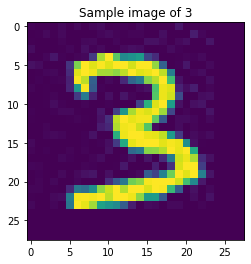

In [7]:
rand_digit = np.random.randint(0, 10)
rand_sample = np.random.randint(0, len(images_all[rand_digit]))
plt.imshow(images_all[rand_digit][rand_sample])
plt.title("Sample image of "+ str(labels[rand_digit][rand_sample]))
plt.show()

# 3. Train/Test Split

In [8]:
y = np.concatenate(labels)
y_one_hot = to_categorical(y)
X = np.concatenate(images_all)
X = np.expand_dims(X, axis=-1)
X = X/255.0

indices = np.arange(len(X))

(
    X_train, 
    X_test, 
    y_train, 
    y_test, 
    train_indices, 
    test_indices)= train_test_split(X, y, indices, test_size = 0.3, random_state = 40)

y_train_one_hot = y_one_hot[train_indices]
y_test_one_hot = y_one_hot[test_indices]

# 4. Accuracy report function

In [9]:
def accuracy_report(y_test, y_pred):
    cm = confusion_matrix(y_test,y_pred)
    acc_report = {}
    labels = np.unique(y_test)
    AA = 0
    for label in labels:
        per_class_acc = cm[label,label]/np.sum(cm[label,:]) * 100
        acc_report["class " + str(label)] = per_class_acc
        AA+=per_class_acc
    AA = AA/len(labels)
    acc_report["OA"] = accuracy_score(y_test, y_pred)*100
    acc_report["AA"] = AA
    
    return acc_report

# 5. CNN MNIST Classification

## 5.1. Building the CNN

In [11]:
N_input = X[0].shape
N_output = y_one_hot[0].shape[0]

cnn_model = Sequential()
cnn_model.add(Conv2D(64, (3,3), input_shape=N_input, activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Conv2D(64, (3,3), activation='relu'))
cnn_model.add(MaxPooling2D(pool_size=(2,2)))
cnn_model.add(Flatten())
cnn_model.add(Dense(64))
cnn_model.add(Dense(N_output, activation='softmax'))
cnn_model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(),metrics=['accuracy'])
cnn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 64)        640       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 64)        36928     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 64)          0         
_________________________________________________________________
flatten (Flatten)            (None, 1600)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                102464    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                6

## 5.2. Training the CNN

In [12]:
epochs = 10
batch_size = 64

In [13]:
history = cnn_model.fit(X_train, y_train_one_hot, epochs=epochs, batch_size=batch_size)

Epoch 1/10
105/766 [===>..........................] - ETA: 1:08 - loss: 0.5907 - accuracy: 0.8241 ETA: 1:09 - loss: 0.6278 

KeyboardInterrupt: 

In [13]:
# cnn_model.save_weights(data_path + "cnn model/cnn_weights_epochs_"+str(epochs)+".h5") 

In [14]:
# cnn_model.load_weights(data_path + "cnn model/cnn_weights_epochs_"+str(epochs)+".h5")

In [17]:
# np.save(data_path + "cnn model/cnn_training_acc_epochs_"+str(epochs), history.history['accuracy'])
# np.save(data_path + "cnn model/cnn_training_loss_epochs_"+str(epochs), history.history['loss'])

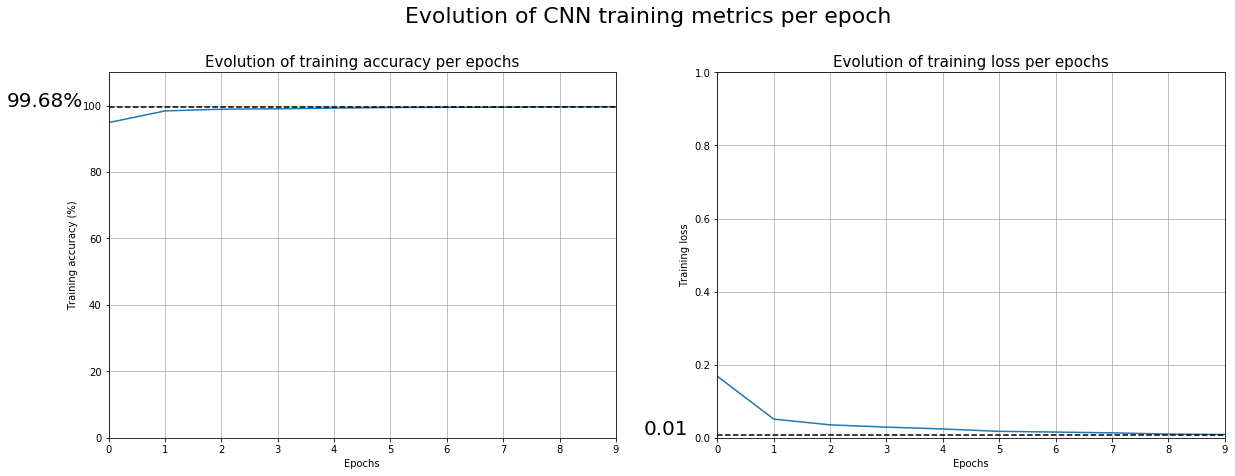

In [15]:
# training_acc = np.load(data_path + "cnn model/cnn_training_acc_epochs_"+str(epochs)+".npy")
# training_acc = np.array(training_acc)*100
# training_loss = np.load(data_path + "cnn model/cnn_training_loss_epochs_"+str(epochs)+".npy")

training_acc=history.history["accuracy"]
training_loss=history.history["loss"]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.plot(training_acc)
ax1.plot(np.ones(len(training_acc))*training_acc[-1], color='k',linestyle = 'dashed')
ax1.set_xlim([0, len(training_acc)-1])
ax1.set_ylim([0, 110])
ax1.text(-1.8, training_acc[-1], "{:.2f}".format(training_acc[-1])+"%", size=20)
ax1.set_xlabel("Epochs")
ax1.set_ylabel("Training accuracy (%)")
ax1.grid()
ax1.set_title("Evolution of training accuracy per epochs", fontsize=15)

ax2.plot(training_loss)
ax2.plot(np.ones(len(training_loss))*training_loss[-1], color='k',linestyle = 'dashed')
ax2.set_xlim([0, len(training_loss)-1])
ax2.set_ylim([0, 1])
ax2.text(-1.3, training_loss[-1], "{:.2f}".format(training_loss[-1]), size=20)
ax2.set_xlabel("Epochs")
ax2.set_ylabel("Training loss")
ax2.grid()
ax2.set_title("Evolution of training loss per epochs", fontsize=15)

fig.subplots_adjust(top=0.85)
fig.suptitle("Evolution of CNN training metrics per epoch", fontsize=22)
plt.show()

## 5.4. Testing the CNN

In [19]:
y_pred_cnn = cnn_model.predict(X_test)
y_pred = [np.argmax(y_pred_elt) for y_pred_elt in y_pred_cnn]
acc_report = accuracy_report(y_test, y_pred)
acc_report_df = pd.DataFrame(data=[round(acc,2) for acc in acc_report.values()], 
                             index=acc_report.keys(), 
                             columns=["ANN accuracy (%)"])
acc_report_df

,ANN accuracy (%)
class 0,99.51
class 1,99.44
class 2,99.22
class 3,98.73
class 4,98.27
class 5,98.22
class 6,99.52
class 7,98.80
class 8,98.91
class 9,98.60


## 5.5. Visualization of the test results

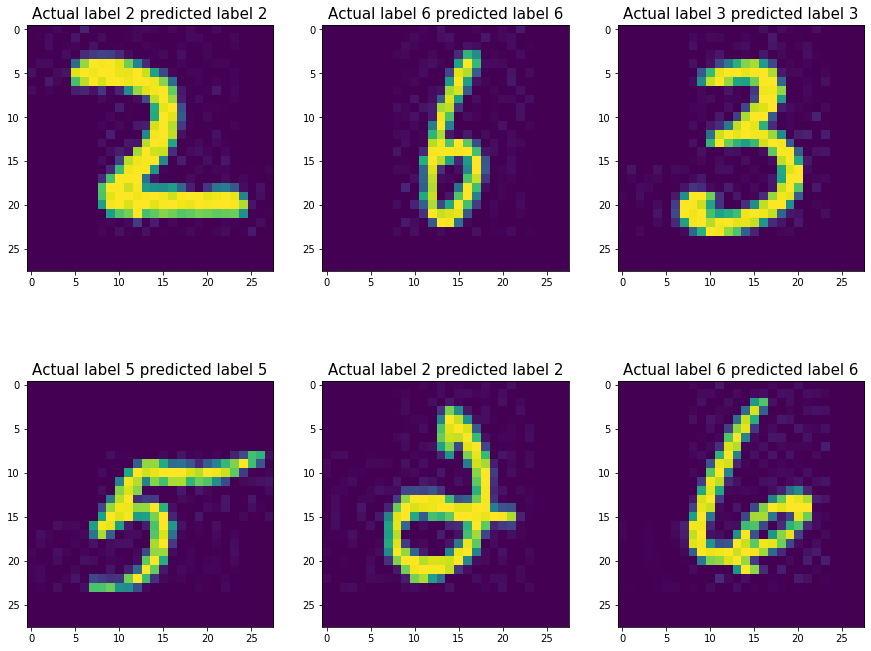

In [20]:
fig, (ax) = plt.subplots(2, 3, figsize=(15,12))

for ax_1 in ax:
    for ax_2 in ax_1:
        rand_test_sample_idx = np.random.randint(0, len(X_test))
        ax_2.imshow(X_test[rand_test_sample_idx].squeeze())
        ax_2.set_title(["Actual label "+str(y_test[rand_test_sample_idx])
                        +" predicted label "+str(y_pred[rand_test_sample_idx])][0], fontsize=15)
plt.show()